In [1]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
from matplotlib.colors import LogNorm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import healpy as hp
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rotate_map(hmap, rot_theta, rot_phi):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[rot_phi,rot_theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


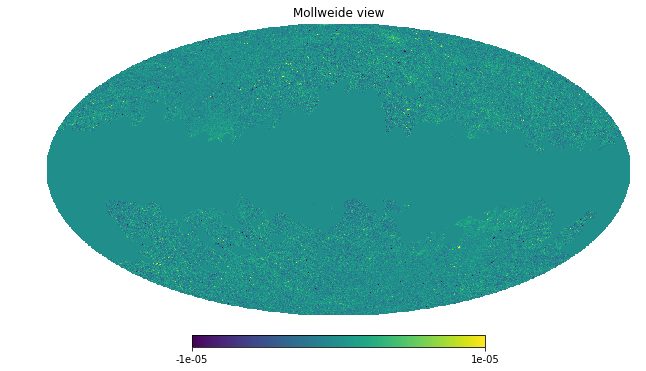

In [3]:
sz_map = hp.read_map('COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits', nest=False)
sz_map_mask = hp.read_map('COM_Mask_Compton-SZMap_2048_R2.00.fits', nest=False)
hp.mollview(sz_map*sz_map_mask, min=-1e-5, max=1e-5)

In [30]:
planck_data = pf.open('HFI_PCCS_SZ-union_R2.08.fits')[1].data

z_pl = planck_data['redshift']
snr_pl = planck_data['SNR']
mass_pl = planck_data['MSZ']
ra_pl = planck_data['ra']
dec_pl = planck_data['dec']

id_snr = np.argsort(snr_pl)[::-1]
snr_pl_sort = snr_pl[id_snr]
print(snr_pl_sort)

mass_pl_sort = mass_pl[id_snr]
z_pl_sort = z_pl[id_snr]
ra_pl_sort = ra_pl[id_snr]
dec_pl_sort = dec_pl[id_snr]

# first cluster has SZ mass M, assume SZ mass scales with M500, assume know R500 for first cluster is 18 arcmin
def M500c_to_R500c(mass, z, cosmo):
    rho_c_z = cosmo.critical_density(z)
    mass_units = mass*u.Msun
    R500c = ((mass_units/(500.*4.*np.pi*rho_c_z/3.))**(1./3.)).to('Mpc')
    return R500c.value

R500_MSZ = M500c_to_R500c(mass_pl_sort[0]*10**14, z_pl_sort[0], cosmo)
Factor = R500_MSZ*(1+z_pl_sort[0])/(18./60/180*np.pi)/cosmo.comoving_distance(z_pl_sort[0]).value
print(Factor)

R500c = (1+z_pl_sort)*M500c_to_R500c(mass_pl_sort*10**14/Factor**3, z_pl_sort, cosmo)/cosmo.comoving_distance(z_pl_sort).value /np.pi*180.*60
R200c = R500c / 0.7
no_R200c_mask = (R200c!=0)

mass_pl_sort = mass_pl_sort[no_R200c_mask]
z_pl_sort = z_pl_sort[no_R200c_mask]
ra_pl_sort = ra_pl_sort[no_R200c_mask]
dec_pl_sort = dec_pl_sort[no_R200c_mask]
R500c = R500c[no_R200c_mask]
R200c = R200c[no_R200c_mask]
print(R200c.shape)
print('R500c in arcmin', R500c)
print('R200c in arcmin', R200c)

M500c = mass_pl_sort*10**14/Factor**3 #Msun
M200c = M500c * (1.4)**3
print('M200c', M200c)


[48.98511  40.754887 39.994656 ...  4.502672  4.50219   4.500935]
1.2225344603067083
(1094,)
R500c in arcmin [17.99999807 15.43385148 15.57554353 ...  2.00508466  3.50675728
  3.09891494]
R200c in arcmin [25.71428296 22.04835925 22.25077647 ...  2.86440665  5.00965326
  4.42702135]


In [32]:
nside = 2048
cluster_master = sz_map*0.0
# define grid to work on
healpix_grid = np.arange(hp.nside2npix(nside))
theta, phi = hp.pix2ang(nside, healpix_grid)
ra = phi/np.pi*180
dec = 90.0 - (theta/np.pi*180)
c2 = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')

for i in range(R200c.shape[0]):
    if R200c[i]>0:
        c1 = SkyCoord(ra_pl_sort[i]*u.degree, dec_pl_sort[i]*u.degree, frame='icrs')
        sep = c1.separation(c2)
        mask_area = (sep.degree<5*R200c[i]/60.0)
        cluster_master[mask_area] = 1.0
        if i%20==0: print(i)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080


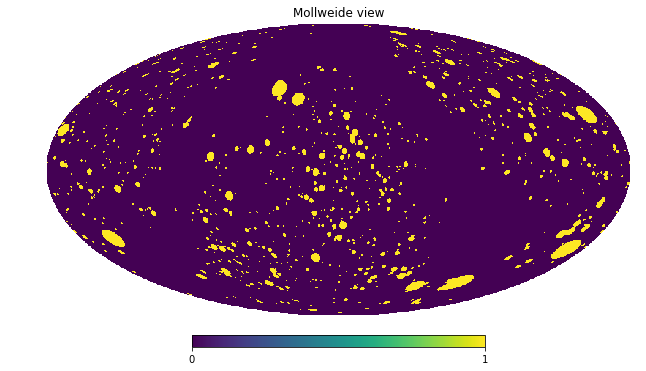

In [33]:
hp.mollview(cluster_master)    

In [35]:
np.savez('cluster_mask.npz', cluster_mask = cluster_master)

In [34]:
ra_c = 30.0
dec_c = 0.0
nside = 2048

# define grid to work on
healpix_grid = np.arange(hp.nside2npix(nside))
theta, phi = hp.pix2ang(nside, healpix_grid)
ra = phi/np.pi*180
dec = 90.0 - (theta/np.pi*180)

c1 = SkyCoord(ra_c*u.degree, dec_c*u.degree, frame='icrs')
c2 = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')
sep = c1.separation(c2)
mask_area = (sep.degree<3)
mask_area2 = (sep.degree<5)

In [36]:
hpix = healpix_grid[mask_area2]

0
good


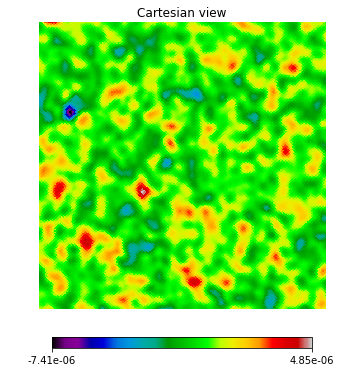

1
2
good


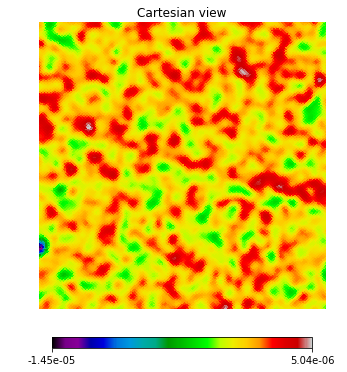

3
good


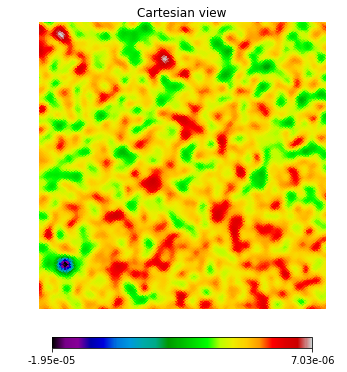

4
5
6
7
8
9
good


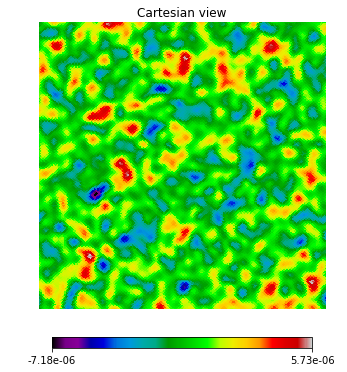

10
good


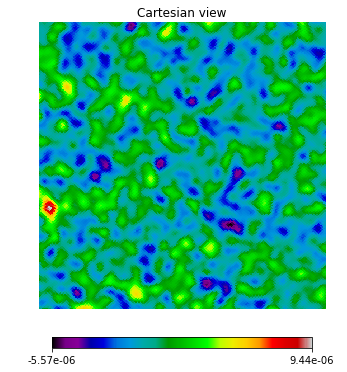

11
good


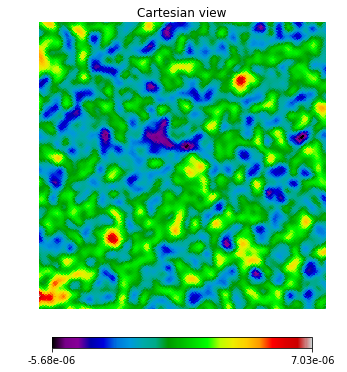

12
13
good


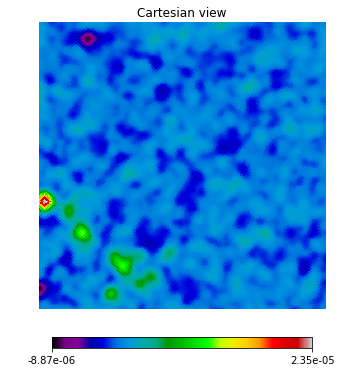

14
15
good


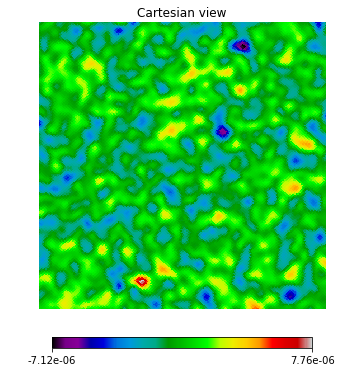

16
good


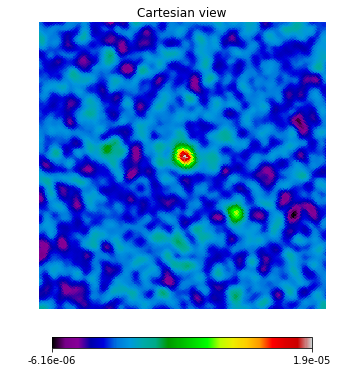

17
good


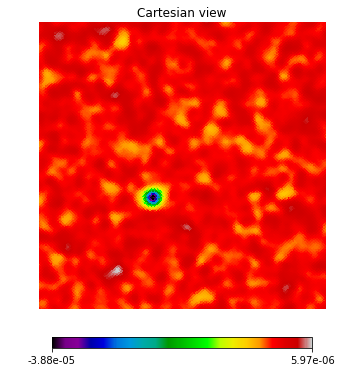

18
19
20
good


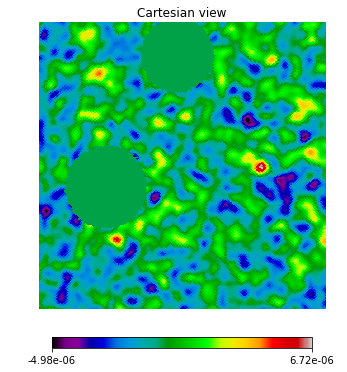

21
22
good


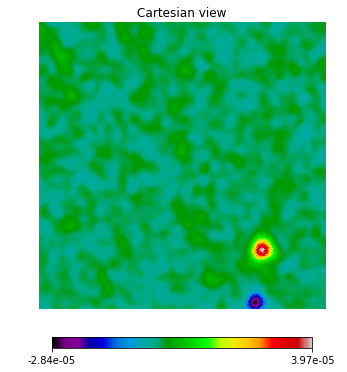

23
24
good


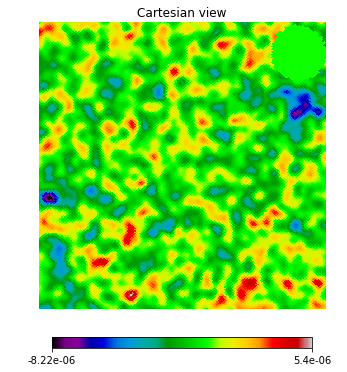

25
26
27
28
29
30
31
good


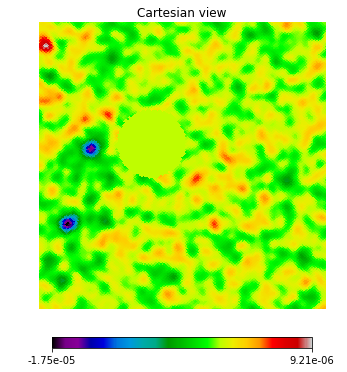

32
33
good


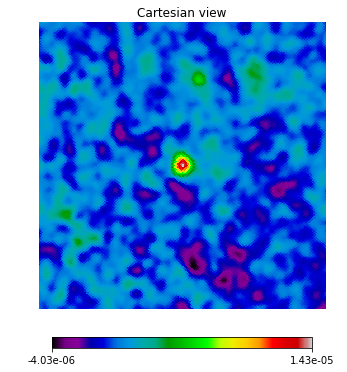

34
35
36
37
38
39
good


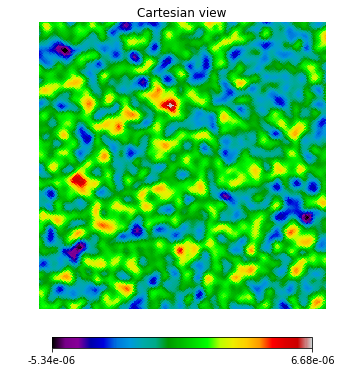

40
good


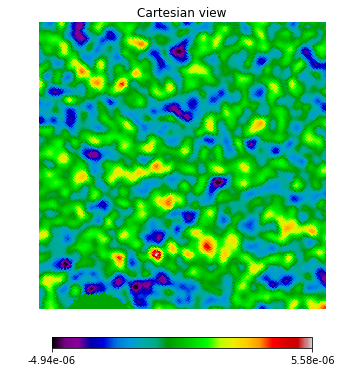

41
42
good


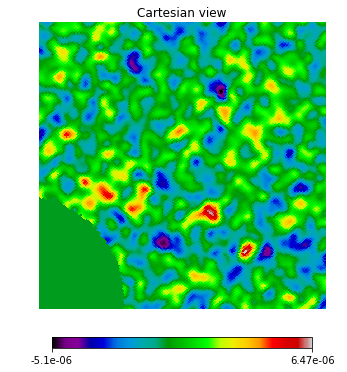

43
44
good


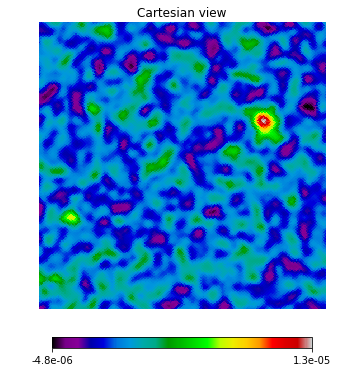

45
46
47
48
49
good


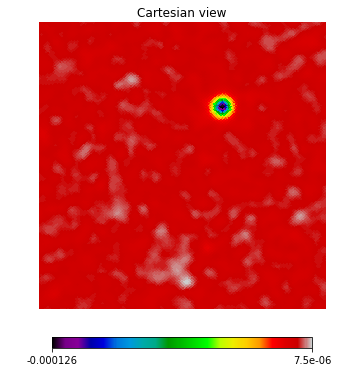

50
51
good


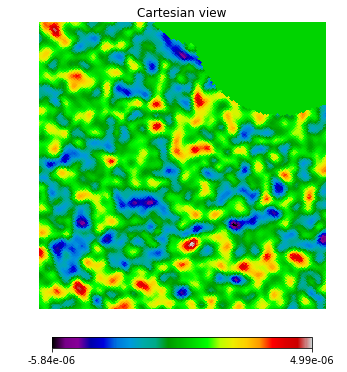

52
53
54
55
56
good


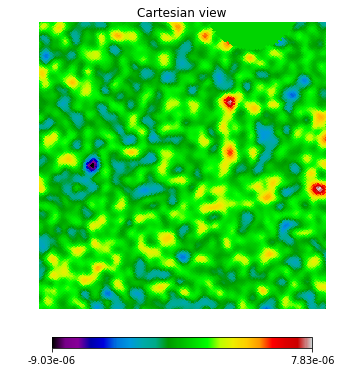

57
58
good


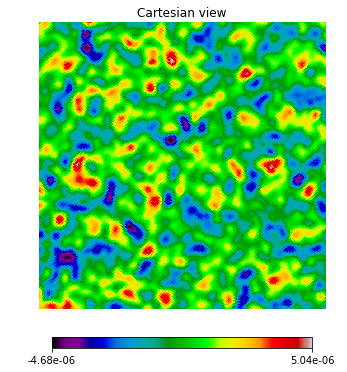

59
good


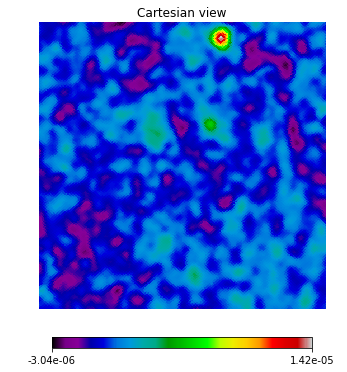

60
61
62
63
good


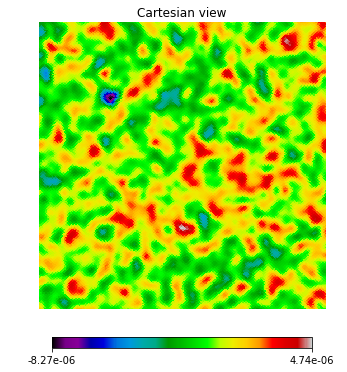

64
good


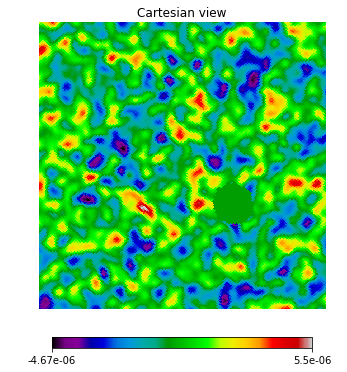

65
good


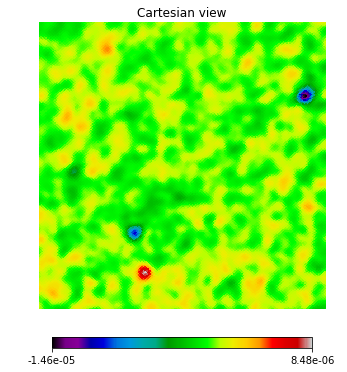

66
67
good


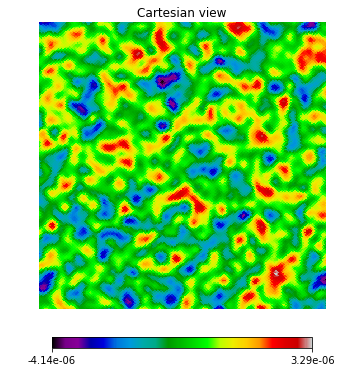

68
69
good


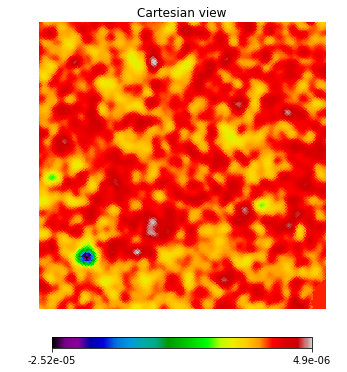

70
71
72
good


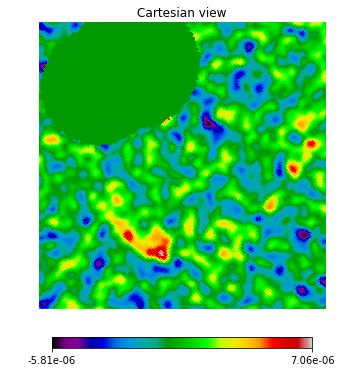

73
74
75
good


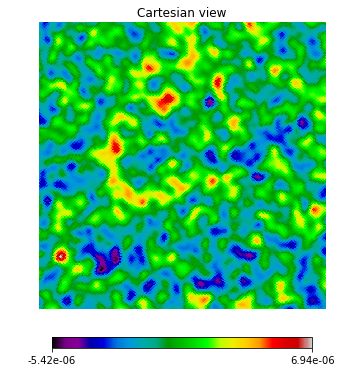

76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
good


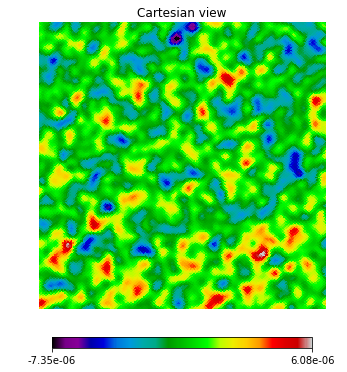

99
100
good


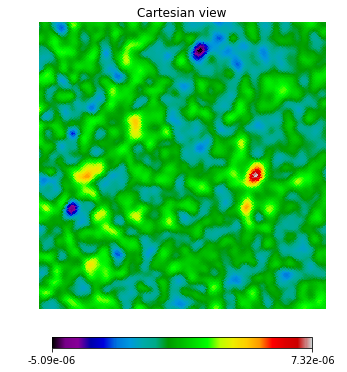

101
102
103
104
105
106
107
good


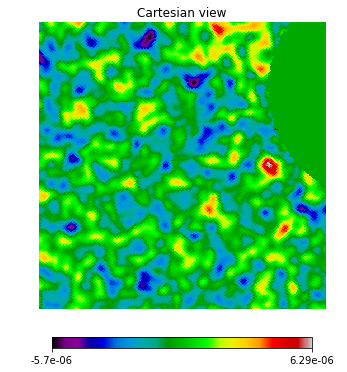

108
109
110
good


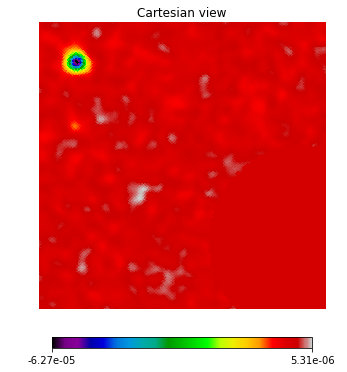

111
good


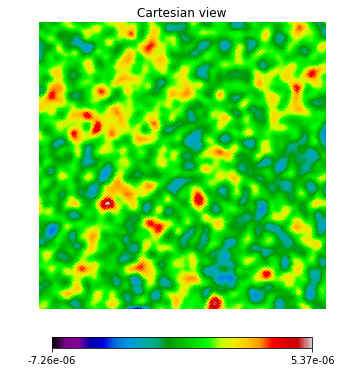

112
113
good


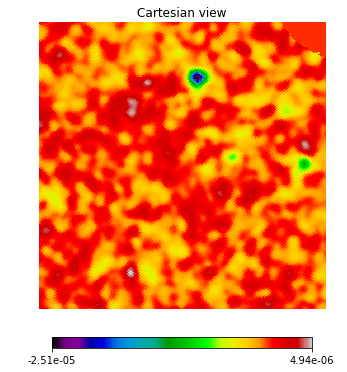

114
115
good


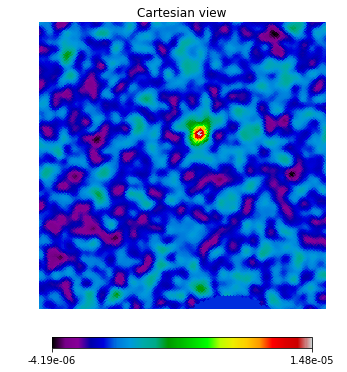

116
117
118
good


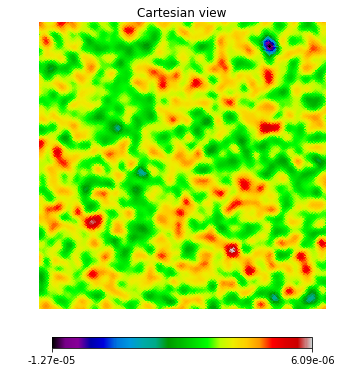

119
120
121
122
123
124
125
126
good


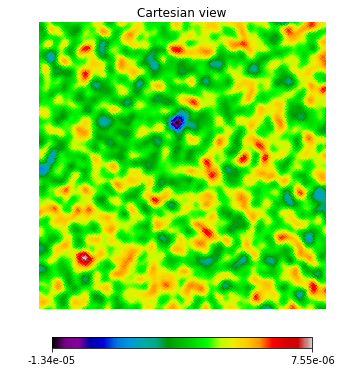

127
good


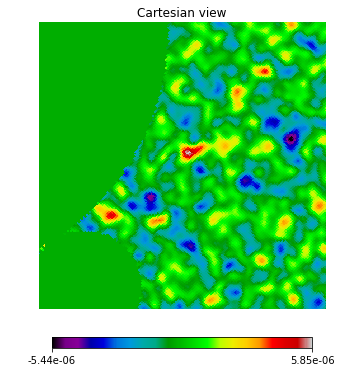

128
129
130
131
132
133
134
135
good


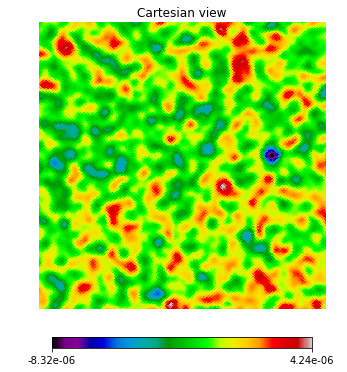

136
good


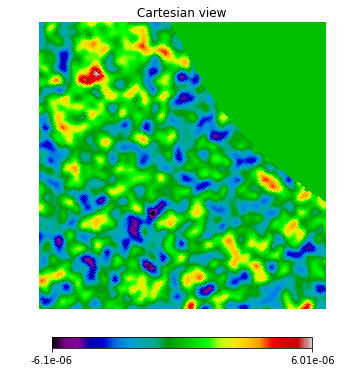

137
good


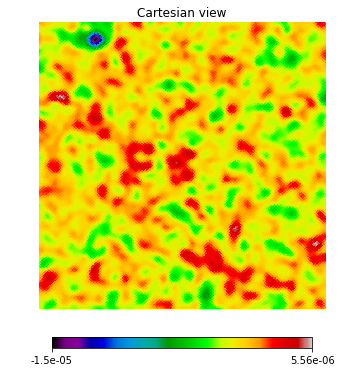

138
good


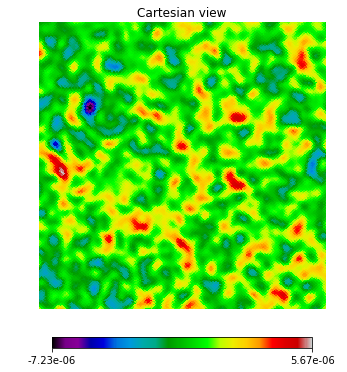

139
good


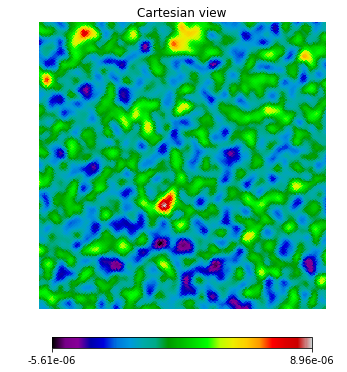

140
good


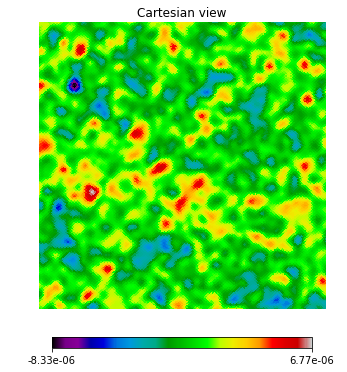

141
good


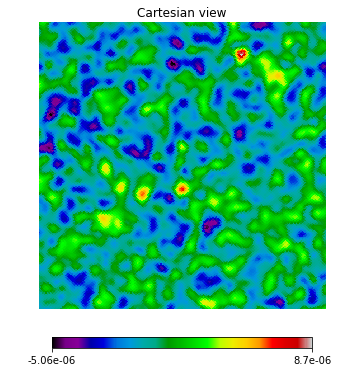

142
143
good


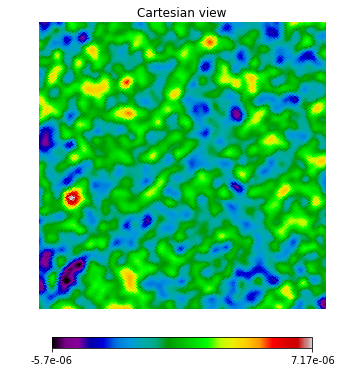

144
good


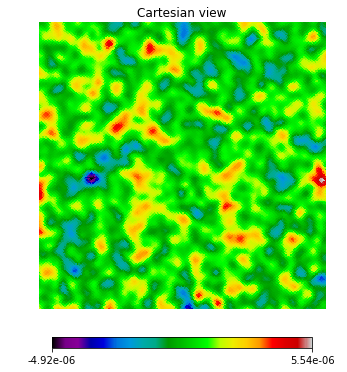

145
146
good


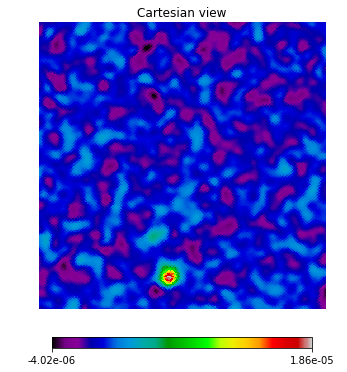

147
148
149
150
good


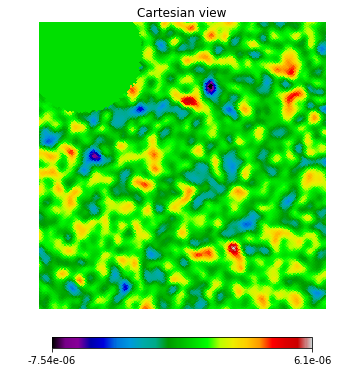

151
good


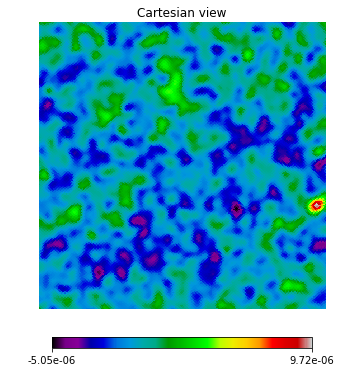

152
153
154
155
156
good


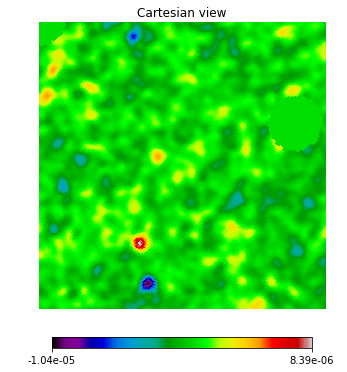

157
158
good


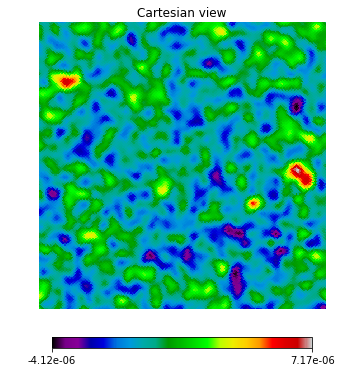

159
160
161
162
good


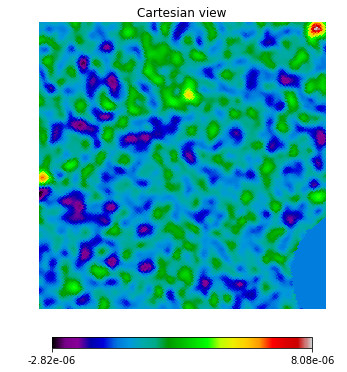

163
164
165
good


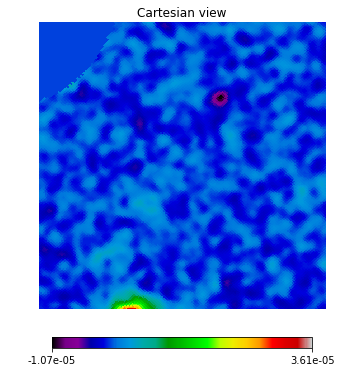

166
167
good


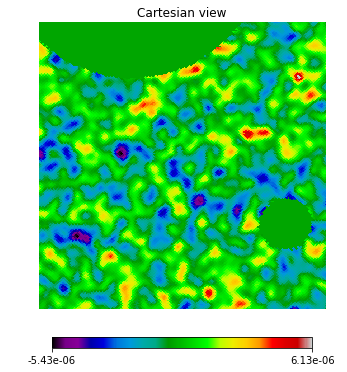

168
169
170
171
good


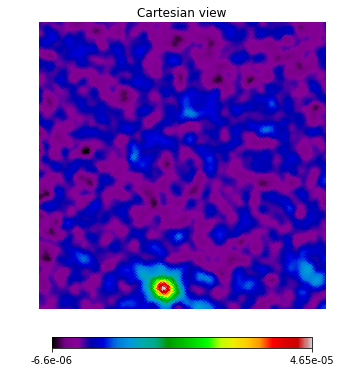

172
173
174
175
good


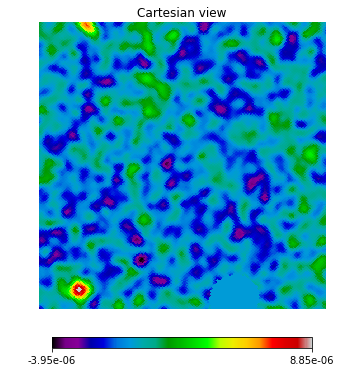

176
177
good


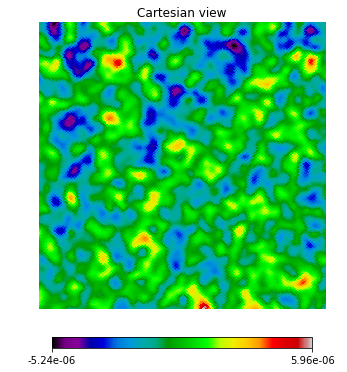

178
good


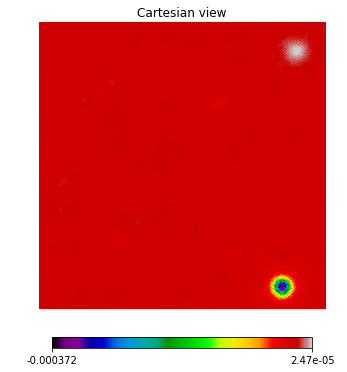

179
180
181
182
good


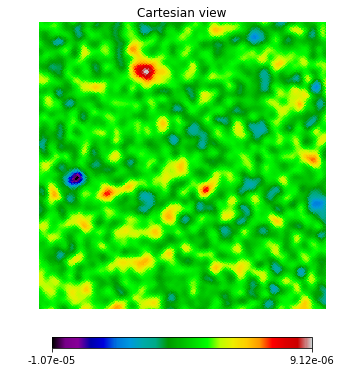

183
good


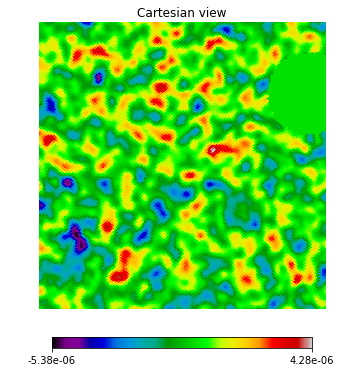

184
good


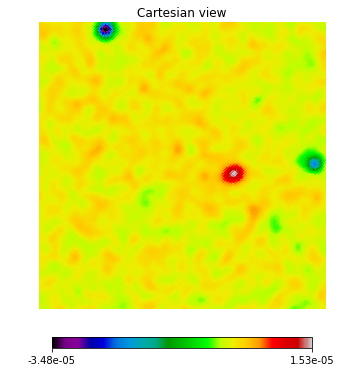

185
186
187
188
189
190
191
good


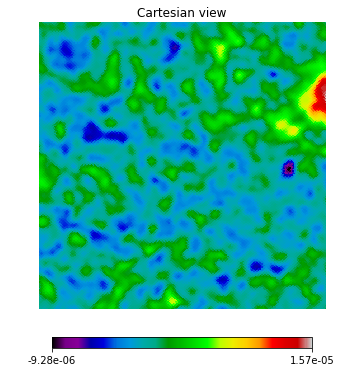

192
193
good


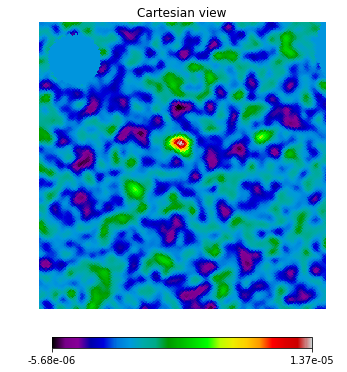

194
195
196
197
198
good


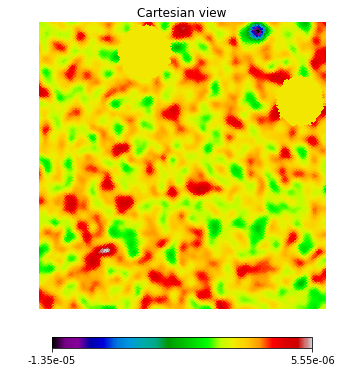

199
good


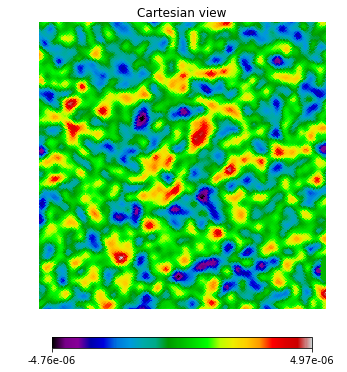

In [43]:
n = 34
for i in range(200):
    print(i)
    rot_theta = 2*np.pi*np.random.random() - np.pi
    rot_phi = 2*np.pi*np.random.random()
    if np.abs(rot_theta)>np.pi/6:
        rot = rotate_map(sz_map*sz_map_mask, rot_theta, rot_phi)
        if (len(rot[mask_area][rot[mask_area]==0])<10):
            print('good')
            rot2 = rotate_map(cluster_master, rot_theta, rot_phi)
            hp.cartview(rot*(rot2==0), lonra=[28,32], latra=[-2,2],cmap='nipy_spectral')
            mplot.show()

            np.savez('noise_map_'+str(n)+'.npz', hpix=hpix, noise=rot[hpix], cluster_mask=rot2[hpix])
            n+=1
    else:
        continue

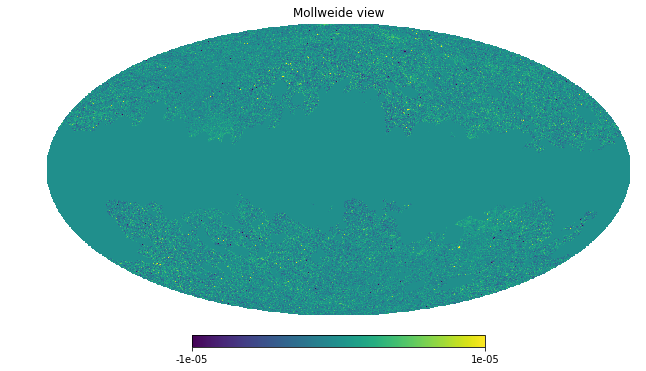

In [46]:
hp.mollview(sz_map*sz_map_mask*(cluster_master==0), min=-1e-5, max=1e-5)

In [47]:
all_map = sz_map*sz_map_mask*(cluster_master==0)
np.mean(all_map[all_map!=0])

-2.735104015964076e-08

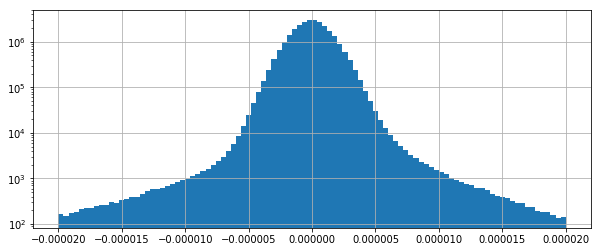

In [57]:
mplot.figure(figsize=(10,4))
mplot.hist(all_map[all_map!=0], range=(-2e-5,2e-5), bins=100)
mplot.grid()
mplot.yscale('log')